# Import necessary depencencies

In [1]:
import pandas as pd
import numpy as np
import text_normalizer as tn
np.set_printoptions(precision=2, linewidth=80)

# Load and normalize data

In [2]:
dataset = pd.read_csv(r'movie_reviews.csv')
print(dataset.head())
print("\n")
print("Number of rows and columns:",dataset.shape)
print("\n")
#check for missing values
print("Number of missing values:")
print(dataset.isnull().sum())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


Number of rows and columns: (50000, 2)


Number of missing values:
review       0
sentiment    0
dtype: int64


In [3]:
reviews = np.array(dataset['review'])
sentiments = np.array(dataset['sentiment'])

# extract data for model evaluation
test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]
sample_review_ids = [7626, 3533, 13010]

# normalize dataset
norm_test_reviews = tn.normalize_corpus(test_reviews)

In [74]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report 
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

def model_performance(true_labels,predicted_labels,classes):    
        conf_matrix=confusion_matrix(true_labels,predicted_labels)
        df_cm=pd.DataFrame(conf_matrix,index=classes,columns=classes)

        print('Accuracy:  {:2.2%} '.format(accuracy_score(true_labels,predicted_labels)))
        print('Precision: {:2.2%} '.format(precision_score(true_labels,predicted_labels, average='weighted')))
        print('Recall:    {:2.2%} '.format(recall_score(true_labels,predicted_labels, average='weighted')))
        print('F1 Score:  {:2.2%} '.format(f1_score(true_labels,predicted_labels, average='weighted')))   
        print("\n")
        print("Classification Report: \n",)
        print( classification_report(true_labels,predicted_labels))
        plt.figure(figsize=(5,5))
        sn.heatmap(df_cm, annot=True, fmt=".3f", linewidths=.5, square = True)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        print("\nConfusion matrix:")
        score = accuracy_score(true_labels,predicted_labels)
        all_sample_title = 'Accuracy Score: {0}%'.format(np.round(score,2)*100)
        plt.title(all_sample_title, size = 12)

# Sentiment Analysis with AFINN

In [76]:
!pip install afinn
from afinn import Afinn

afn = Afinn(emoticons=True) 

## Predict sentiment for sample reviews

In [77]:
for review, sentiment in zip(test_reviews[sample_review_ids], test_sentiments[sample_review_ids]):
    print('REVIEW:', review)
    print('Actual Sentiment:', sentiment)
    print('Predicted Sentiment polarity:', afn.score(review))
    print('-'*60)

REVIEW: no comment - stupid movie, acting average or worse... screenplay - no sense at all... SKIP IT!
Actual Sentiment: negative
Predicted Sentiment polarity: -7.0
------------------------------------------------------------
REVIEW: I don't care if some people voted this movie to be bad. If you want the Truth this is a Very Good Movie! It has every thing a movie should have. You really should Get this one.
Actual Sentiment: positive
Predicted Sentiment polarity: 3.0
------------------------------------------------------------
REVIEW: Worst horror film ever but funniest film ever rolled in one you have got to see this film it is so cheap it is unbeliaveble but you have to see it really!!!! P.s watch the carrot
Actual Sentiment: positive
Predicted Sentiment polarity: -3.0
------------------------------------------------------------


## Predict sentiment for test dataset

In [78]:
sentiment_polarity = [afn.score(review) for review in test_reviews]
predicted_sentiments = ['positive' if score >= 1.0 else 'negative' for score in sentiment_polarity]

## Evaluate model performance

Accuracy:  71.18% 
Precision: 72.89% 
Recall:    71.18% 
F1 Score:  70.62% 


Classification Report: 

              precision    recall  f1-score   support

    negative       0.79      0.57      0.67      7490
    positive       0.67      0.85      0.75      7510

    accuracy                           0.71     15000
   macro avg       0.73      0.71      0.71     15000
weighted avg       0.73      0.71      0.71     15000


Confusion matrix:


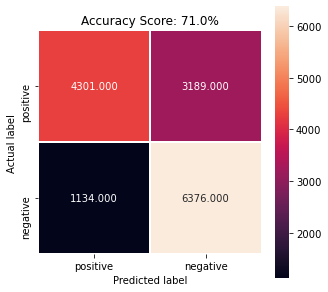

In [79]:
model_performance(true_labels=test_sentiments, predicted_labels=predicted_sentiments, classes=['positive', 'negative'])

# Sentiment Analysis with SentiWordNet

In [80]:
from nltk.corpus import sentiwordnet as swn
word = list(swn.senti_synsets('awesome','a'))[0]
print("Positive score : ",word.pos_score())
print("Negative score : ",word.neg_score())
print("Objective score : ",word.obj_score())

Positive score :  0.875
Negative score :  0.125
Objective score :  0.0


## Build model

In [81]:
def analyze_sentiwordnet_func(review,verbose=False):
    tagged_text=[(token.text,token.tag_) for token in tn.nlp(review)]
    pos_score=neg_score=token_count=obj_score=0

    for word, tag in tagged_text:
        ss_set = None
        if 'NN' in tag and list(swn.senti_synsets(word, 'n')):
            ss_set = list(swn.senti_synsets(word, 'n'))[0]
        elif 'VB' in tag and list(swn.senti_synsets(word, 'v')):
            ss_set = list(swn.senti_synsets(word, 'v'))[0]
        elif 'JJ' in tag and list(swn.senti_synsets(word, 'a')):
            ss_set = list(swn.senti_synsets(word, 'a'))[0]
        elif 'RB' in tag and list(swn.senti_synsets(word, 'r')):
            ss_set = list(swn.senti_synsets(word, 'r'))[0]       
        if ss_set:
            pos_score += ss_set.pos_score()
            neg_score += ss_set.neg_score()
            obj_score += ss_set.obj_score()
            token_count += 1
      
    final_score=pos_score-neg_score
    norm_final_score = round(float(final_score)/token_count,3)
    final_sentiment ='positive' if norm_final_score>=0 else 'negative'
    if verbose:
        print("Sentiment: ",final_sentiment)
        print("Objectivity: ",round(float(obj_score)/token_count,3))
        print("Positivity: ",round(float(pos_score)/token_count,3))
        print("Negativity: ",round(float(neg_score)/token_count,3))
    return final_sentiment

## Predict sentiment for sample reviews

In [82]:
for review, sentiment in zip(test_reviews[sample_review_ids], test_sentiments[sample_review_ids]):
    print('REVIEW:', review)
    print('Actual Sentiment:', sentiment)
    pred = analyze_sentiwordnet_func(review, verbose=True)    
    print('-'*60)

REVIEW: no comment - stupid movie, acting average or worse... screenplay - no sense at all... SKIP IT!
Actual Sentiment: negative
Sentiment:  negative
Objectivity:  0.681
Positivity:  0.097
Negativity:  0.222
------------------------------------------------------------
REVIEW: I don't care if some people voted this movie to be bad. If you want the Truth this is a Very Good Movie! It has every thing a movie should have. You really should Get this one.
Actual Sentiment: positive
Sentiment:  positive
Objectivity:  0.756
Positivity:  0.188
Negativity:  0.056
------------------------------------------------------------
REVIEW: Worst horror film ever but funniest film ever rolled in one you have got to see this film it is so cheap it is unbeliaveble but you have to see it really!!!! P.s watch the carrot
Actual Sentiment: positive
Sentiment:  positive
Objectivity:  0.8
Positivity:  0.125
Negativity:  0.075
------------------------------------------------------------


## Predict sentiment for test dataset

In [83]:
predicted_sentiments = [analyze_sentiwordnet_func(review, verbose=False) for review in norm_test_reviews]

## Evaluate model performance

Accuracy:  69.47% 
Precision: 69.49% 
Recall:    69.47% 
F1 Score:  69.46% 


Classification Report: 

              precision    recall  f1-score   support

    negative       0.70      0.68      0.69      7490
    positive       0.69      0.71      0.70      7510

    accuracy                           0.69     15000
   macro avg       0.69      0.69      0.69     15000
weighted avg       0.69      0.69      0.69     15000


Confusion matrix:


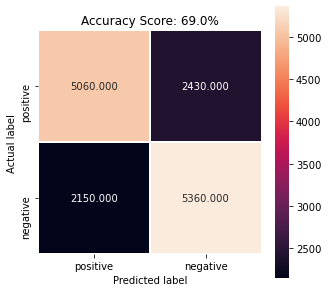

In [84]:
# Performance Metrics on SentiWordNet
model_performance(true_labels=test_sentiments, predicted_labels=predicted_sentiments, 
                                  classes=['positive', 'negative'])

# Sentiment Analysis with VADER

In [85]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Build model

In [86]:
def func_intensity_analyser(review,threshold=0.1,verbose=False):
    analyzer=SentimentIntensityAnalyzer()
    scores=analyzer.polarity_scores(review)

    agg_score=scores['compound']
    final_sentiment='positive' if agg_score>=threshold else 'negative'
    if verbose:
        positive = round(scores['pos'],2)*100
        final= round(agg_score,2)*100
        negative=round(scores['neg'],2)*100
        neutral =round(scores['neu'],2)*100

        print(f'POSITIVE : {positive}%')
        print(f'NEGATIVE : {negative}%')
        print(f'NEUTRAL : {neutral}%')
        print(f'FINAL : {final}')
        print(f'SENTIMENT : {final_sentiment}')
    return final_sentiment

## Predict sentiment for sample reviews

In [87]:
for review, sentiment in zip(test_reviews[sample_review_ids], test_sentiments[sample_review_ids]):
    print('REVIEW:', review)
    print('Actual Sentiment:', sentiment)
    pred = func_intensity_analyser(review, threshold=0.4, verbose=True)    
    print('-'*60)

REVIEW: no comment - stupid movie, acting average or worse... screenplay - no sense at all... SKIP IT!
Actual Sentiment: negative
POSITIVE : 0.0%
NEGATIVE : 40.0%
NEUTRAL : 60.0%
FINAL : -80.0
SENTIMENT : negative
------------------------------------------------------------
REVIEW: I don't care if some people voted this movie to be bad. If you want the Truth this is a Very Good Movie! It has every thing a movie should have. You really should Get this one.
Actual Sentiment: positive
POSITIVE : 17.0%
NEGATIVE : 14.000000000000002%
NEUTRAL : 69.0%
FINAL : -16.0
SENTIMENT : negative
------------------------------------------------------------
REVIEW: Worst horror film ever but funniest film ever rolled in one you have got to see this film it is so cheap it is unbeliaveble but you have to see it really!!!! P.s watch the carrot
Actual Sentiment: positive
POSITIVE : 11.0%
NEGATIVE : 11.0%
NEUTRAL : 77.0%
FINAL : 49.0
SENTIMENT : positive
-------------------------------------------------------

## Predict sentiment for test dataset

In [88]:
predicted_sentiments = [func_intensity_analyser(review, threshold=0.4, verbose=False) for review in test_reviews]

## Evaluate model performance

Accuracy:  71.09% 
Precision: 72.38% 
Recall:    71.09% 
F1 Score:  70.66% 


Classification Report: 

              precision    recall  f1-score   support

    negative       0.78      0.59      0.67      7490
    positive       0.67      0.83      0.74      7510

    accuracy                           0.71     15000
   macro avg       0.72      0.71      0.71     15000
weighted avg       0.72      0.71      0.71     15000


Confusion matrix:


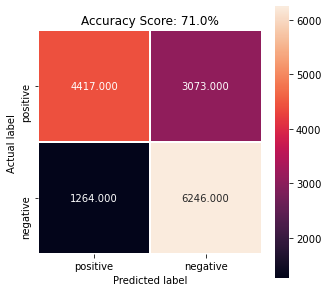

In [89]:
model_performance(true_labels=test_sentiments, predicted_labels=predicted_sentiments, 
                                  classes=['positive', 'negative'])